In [17]:
import os
from rubin_sim.scheduler.utils import Sky_area_generator
import healpy as hp
import numpy as np
from rubin_sim.data import get_data_dir
from astropy.io import fits

In [93]:
class gal_plane_footprint_generator(Sky_area_generator):

    def add_gal_plane_region(self, filter_ratios, label='gal_plane',
                            priority_threshold=0.3, pencilbeams='small'):
        """Method to create a map region from pre-calculated maps of desired
        survey regions in the Galactic Plane.

        The maps indicate the relative priority of each HEALpix across the sky.
        This can be used to vary the selected survey region by decreasing the
        priority_threshold parameter (thereby selecting a larger region) or
        conversely by increasing it (limiting the survey to a smaller region).
        priority_threshold values between 0.3 - map.max() (~1.5) are recommended.

        Two alternative maps are available.  The default ('small' pencilbeams)
        includes 20 single-pointing pencilbeam fields distributed across the
        Galactic Plane.  The alternative ('alt' pencilbeams) map includes 4 larger pencilbeam
        fields at selected locations towards the galactic arms.
        """

        # Since this method is designed to outline the survey region footprint,
        # and labels pixels according to survey region in a filter-agnostic way,
        # we use the i-band priority map to define the survey region.
        self.MAP_DIR = get_data_dir()
        if pencilbeams == 'small':
            self.MAP_FILE_ROOT_NAME = "priority_GalPlane_footprint_map_data_i.fits"
        else:
            self.MAP_FILE_ROOT_NAME = "priority_GalPlane_footprint_alt_map_data_i.fits"

        file_path = os.path.join(
            self.MAP_DIR,
            "maf",
            self.MAP_FILE_ROOT_NAME
            )
        map_data_table = self.load_map_data(file_path)

        # The priority threshold corresponds to a threshold in stellar density,
        # which is used to identify the HEALpixels of interest for the survey
        # region.
        temp_map = np.zeros(len(map_data_table['combined_map']))
        survey_region_pixels = np.where(map_data_table['combined_map'] >= priority_threshold)[0]
        temp_map[survey_region_pixels] = 1.0

        # Resample temp_map to ensure that it matches the NSIDE parameter
        # being used for the current simulation:
        resampled_map = hp.ud_grade(temp_map, self.nside)

        # Ensure designated pixels are not overriden
        # NOTE: Labeling pixels independently of the filter selection
        # implicitly assumes that the survey footprint is the same in all
        # filters.  This does not necessarily hold true for all regions in
        # the Galactic Plane
        indx = np.where((resampled_map > 0) & (self.pix_labels == ""))
        self.pix_labels[indx] = label

        for filtername in filter_ratios.keys():
            self.healmaps[filtername][indx] = filter_ratios[filtername]

    def load_map_data(self,file_path):

        with fits.open(file_path) as hdul:
            map_data_table = hdul[1].data

        return map_data_table

    def return_maps(
        self,
        magellenic_clouds_ratios={"u": 0.32,"g": 0.4,"r": 1.0,"i": 1.0,"z": 0.9,"y": 0.9,},
        scp_ratios={"u": 0.1, "g": 0.1, "r": 0.1, "i": 0.1, "z": 0.1, "y": 0.1},
        nes_ratios={"g": 0.28, "r": 0.4, "i": 0.4, "z": 0.28},
        dusty_plane_ratios={"u": 0.1,"g": 0.28, "r": 0.28,"i": 0.28,"z": 0.28,"y": 0.1,},
        low_dust_ratios={"u": 0.32, "g": 0.4, "r": 1.0, "i": 1.0, "z": 0.9, "y": 0.9},
        bulge_ratios={"u": 0.18, "g": 1.0, "r": 1.05, "i": 1.05, "z": 1.0, "y": 0.23},
        virgo_ratios={"u": 0.32, "g": 0.4, "r": 1.0, "i": 1.0, "z": 0.9, "y": 0.9},

        gal_plane_ratios = {"u": 0.18, "g": 1.0, "r": 1.05, "i": 1.05, "z": 1.0, "y": 0.23},
        ):
        # Array to hold the labels for each pixel
        self.pix_labels = np.zeros(hp.nside2npix(self.nside), dtype="U20")
        self.healmaps = np.zeros(
            hp.nside2npix(self.nside),
            dtype=list(zip(["u", "g", "r", "i", "z", "y"], [float] * 7)),
        )

        # Note, order here matters. Once a HEALpix is set and labled, subsequent add_ methods
        # will not override that pixel.
        self.add_gal_plane_region(gal_plane_ratios)

        self.add_magellanic_clouds(magellenic_clouds_ratios)
        self.add_lowdust_wfd(low_dust_ratios)
        self.add_virgo_cluster(virgo_ratios)
        self.add_bulge(bulge_ratios)
        self.add_nes(nes_ratios)
        self.add_dusty_plane(dusty_plane_ratios)
        self.add_scp(scp_ratios)

        return self.healmaps, self.pix_labels



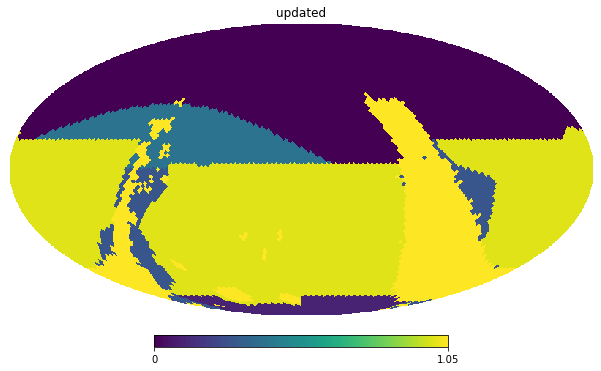

In [94]:
sag = gal_plane_footprint_generator()
sky_maps, labels = sag.return_maps()
hp.mollview(sky_maps['r'], title='updated')